Import the neccesary libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Data Loading

In [46]:
try:
    df = pd.read_csv("coin_Tether.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'coin_Tether.csv' was not found")
    exit()


df

Data loaded successfully!


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Tether,USDT,2015-02-26 23:59:59,1.212320,1.194710,1.210420,1.205740,5.955460e+00,3.033642e+05
1,2,Tether,USDT,2015-03-02 23:59:59,0.607890,0.568314,0.571249,0.606502,3.032500e+00,1.525959e+05
2,3,Tether,USDT,2015-03-03 23:59:59,0.606229,0.604416,0.605129,0.606229,3.031130e+00,1.525272e+05
3,4,Tether,USDT,2015-03-06 23:59:59,1.000000,1.000000,1.000000,1.000000,9.264720e+01,2.516000e+05
4,5,Tether,USDT,2015-03-07 23:59:59,1.000000,1.000000,1.000000,1.000000,5.819680e+04,2.516000e+05
...,...,...,...,...,...,...,...,...,...,...
2313,2314,Tether,USDT,2021-07-02 23:59:59,1.000830,0.999991,1.000301,1.000033,4.562659e+10,6.237592e+10
2314,2315,Tether,USDT,2021-07-03 23:59:59,1.000674,0.999914,1.000046,0.999956,4.119499e+10,6.237115e+10
2315,2316,Tether,USDT,2021-07-04 23:59:59,1.000165,0.998902,0.999987,0.999501,4.306666e+10,6.234274e+10
2316,2317,Tether,USDT,2021-07-05 23:59:59,1.001040,0.999426,0.999426,1.000667,4.721585e+10,6.241550e+10


Data Preprocessing

In [47]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64


In [48]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


In [49]:
# Rename the columns for clarity and consistency
df.rename(columns={
    "SNo":"serial_number",
    "Name":"name",
    "Symbol":"symbol",
    "Date":"date",
    "High":"high",
    "Low":"low",
    "Open":"open",
    "Close":"close",
    "Volume":"volume",
    "Marketcap":"marketcap"
},inplace=True)

In [50]:
# Convert the "date" column to datetime objects
df["date"] = pd.to_datetime(df["date"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   serial_number  2318 non-null   int64         
 1   name           2318 non-null   object        
 2   symbol         2318 non-null   object        
 3   date           2318 non-null   datetime64[ns]
 4   high           2318 non-null   float64       
 5   low            2318 non-null   float64       
 6   open           2318 non-null   float64       
 7   close          2318 non-null   float64       
 8   volume         2318 non-null   float64       
 9   marketcap      2318 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 181.2+ KB
None


In [51]:
# Create a list of all relevant column feature columns
features_cols = ["high","low","open","volume","marketcap"]

In [52]:
# Add the Ordinal Date as a new feature
df["ordinal_date"] = df["date"].apply(lambda date : date.toordinal())

In [53]:
# Define the multi-feature matrix (X) by selecting all engineered and direct features
X = df[["ordinal_date"] + features_cols].values

# Y: The target variable remains the close price
y = df["close"].values.reshape(-1,1)

In [54]:
# Keep track of date labels for final visualization
date_labels = [pd.Timestamp.fromordinal(i) for i in df["ordinal_date"].values]

Data Splitting

In [55]:
# Split the data into training (80%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Data Scaling

In [56]:
# Initialize scalers for features and target
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Example usage to avoid ValueError:
# Always use fit_transform or transform, not the scaler object itself.
# X_train_scaled = X_scaler.fit_transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.fit_transform(y_train)

In [57]:
# Fit and transform the training features
X_train_scaled = X_scaler.fit_transform(X_train)

# Transform the test features
X_test_scaled = X_scaler.transform(X_test)

# Fit and transform the target for SVR training (only needed for the target)
y_train_scaled = y_scaler.fit_transform(y_train)

# Dictionary to hold all models results (R_squared,Name)
model_results = {}

Visualization before training

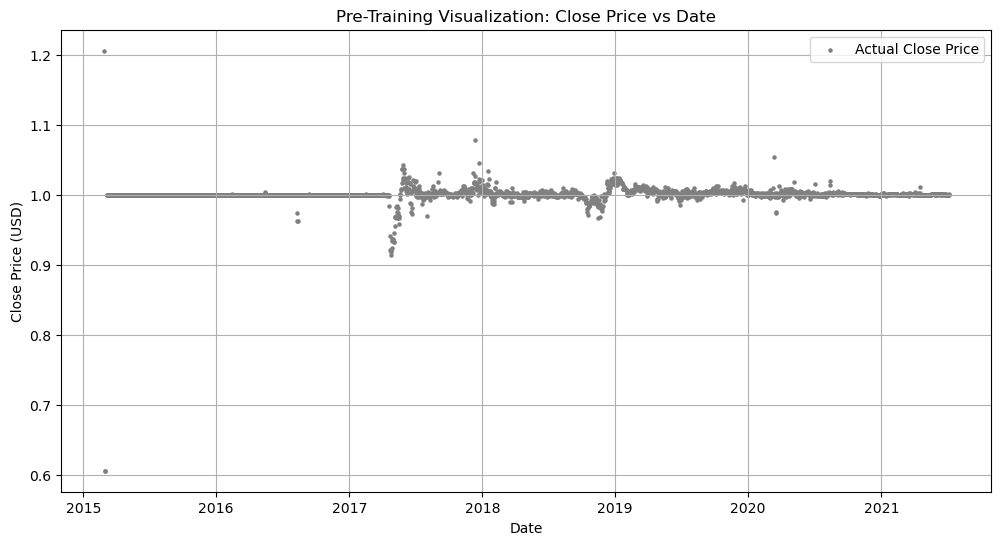

In [58]:
plt.figure(figsize=(12,6))
plt.scatter(date_labels,y,s=5,color="gray",label="Actual Close Price")
plt.title("Pre-Training Visualization: Close Price vs Date")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

Model Training and Evaluation

In [59]:
# List of models to compare
regressors = [
    ("Linear Regresson",LinearRegression()),
    ("Ridge Regression",Ridge(alpha=1.0)),
    ("Lasso Regression",Lasso(alpha=0.01)),
    ("ElasticNet",ElasticNet(alpha=0.1,l1_ratio=0.5)),
    ("Decision Tree Regressor",DecisionTreeRegressor(random_state=42)),
    ("Random Forest Regressor",RandomForestRegressor(random_state=42,n_estimators=100)),
    # SVR requires scaled data for optimal performance
    ('Support Vector Regressor (SVR)', SVR(kernel='rbf', C=100))
 ]

# Loop through all regressors to train, predict and evaluate
for name, model in regressors:
    # All models now use scaled features (X_train_scaled) for training
    if name == "Support Vector Regressor (SVR)":
        # SVR uses scaled features (X_train_scaled) and scaled target (y_train_scaled)
        model.fit(X_train_scaled,y_train_scaled.ravel())
        # Predict on scaled test features
        y_pred_scaled = model.predict(X_test_scaled).reshape(-1,1)
        # Inverse transform the prediction back to the original price scale
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
    else:
        # Other models use scaled features (X_train_scaled) and the original target (y_train)
        model.fit(X_train_scaled,y_train.ravel())
        # Predict using scaled test features
        y_pred = model.predict(X_test_scaled).reshape(-1,1)

    # Calcualte R-squared (Coefficient of Determination)
    r2 = r2_score(y_test,y_pred)

    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))

    # Store the results for the final comparison
    model_results[name] = {"R2":r2, "RMSE":rmse, "model":model}

In [61]:
best_r2 = -np.inf
best_model_name = ""

for name,results in model_results.items():
    print(f"{name}: R-squared = {results['R2']:.4f}, RMSE = {results['RMSE']:.6f}") # Increased RMSE precision

    # Identify the model with the highest R-squared score
    if results["R2"] > best_r2:
        best_r2 = results["R2"]
        best_model_name = name

    print("="* 50)
    print(f"BEST MODEL SELECTED: {best_model_name} (R-squared: {best_r2:.4f})")
    print("="*50)

Linear Regresson: R-squared = 0.8396, RMSE = 0.003650
BEST MODEL SELECTED: Linear Regresson (R-squared: 0.8396)
Ridge Regression: R-squared = 0.8397, RMSE = 0.003650
BEST MODEL SELECTED: Ridge Regression (R-squared: 0.8397)
Lasso Regression: R-squared = 0.4484, RMSE = 0.006770
BEST MODEL SELECTED: Ridge Regression (R-squared: 0.8397)
ElasticNet: R-squared = -0.0010, RMSE = 0.009120
BEST MODEL SELECTED: Ridge Regression (R-squared: 0.8397)
Decision Tree Regressor: R-squared = 0.7097, RMSE = 0.004911
BEST MODEL SELECTED: Ridge Regression (R-squared: 0.8397)
Random Forest Regressor: R-squared = 0.8449, RMSE = 0.003590
BEST MODEL SELECTED: Random Forest Regressor (R-squared: 0.8449)
Support Vector Regressor (SVR): R-squared = 0.8294, RMSE = 0.003765
BEST MODEL SELECTED: Random Forest Regressor (R-squared: 0.8449)


Visualization of the Best's Model Performance

In [63]:
# Find the best model by R2 score
best_model_name = max(model_results, key=lambda k: model_results[k]["R2"])
best_model = model_results[best_model_name]["model"]

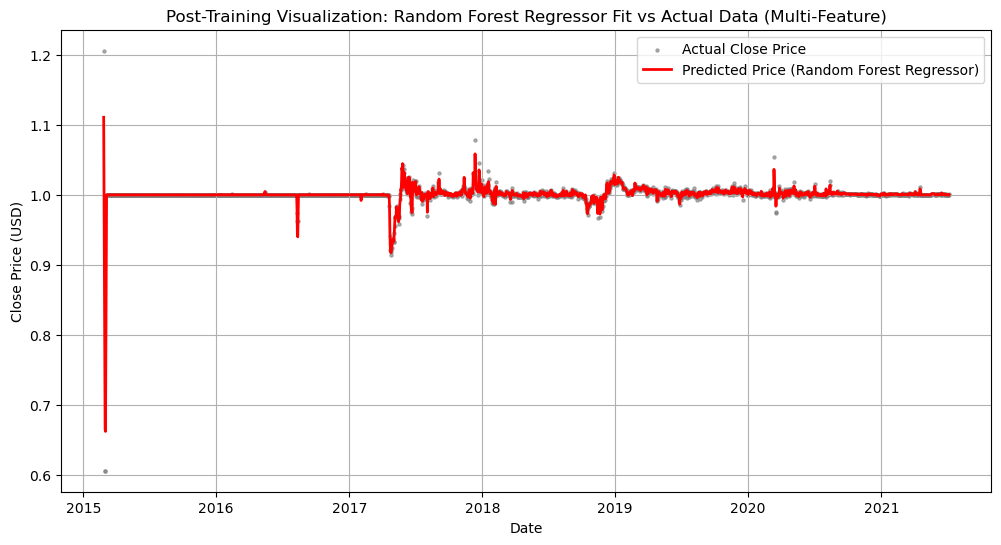

In [66]:
# To visualize the fit over the whole dataset, we predict on all X data points
# First, transform the full dataset X
X_full_scaled = X_scaler.transform(X)

# Predict based on the best model
if best_model_name == "Support Vector Regression":
    # Predict using the scaled entire dataset
    y_pred_full_scaled = best_model.predict(X_full_scaled).reshape(-1,1)
    # Inverse transform to get actual price prediction
    y_pred_full = y_scaler.inverse_transform(X_full_scaled).reshape(-1,1)
else:
    # Predict using scaled entire dataset
    y_pred_full = best_model.predict(X_full_scaled).reshape(-1,1)


plt.figure(figsize=(12,6))
# Plot the actual data points
plt.scatter(date_labels,y,s=5,color="gray",alpha=0.6,label="Actual Close Price")
# Plot the best model's predictions as a line
plt.plot(date_labels,y_pred_full,color="red",linewidth=2,label=f"Predicted Price ({best_model_name})")

plt.title(f"Post-Training Visualization: {best_model_name} Fit vs Actual Data (Multi-Feature)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()